In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [3]:
import plotly.figure_factory as ff

In [4]:
trees = pd.read_csv('data/black_spruce.csv')

In [5]:
def jitter(data, amt=0.2):
    return data + amt * (np.random.rand(len(data)) - 0.5)

# Modeling and Classification

We'd like to create a model that explains the susceptibility of trees to windthrow. In other words, we need to build a model for a two-level nominal feature, fallen or standing. When the response variable is nominal, this modeling task is called *classification*. In this case there are only two levels, so this task is more specifically called *binary classification*.

## A Constant Model

Let's start by considering the simplest model: a constant model that always predicts one class. We'll use $ C $ to denote the constant model's prediction. For our windthrow dataset, this model will either predict $ C = \text{standing} $ or $ C = \text{fallen} $ for every input.

In classification, we want to track how often our model predicts the correct category. For now, we'll do this simply: we'll use a count of the correct predictions. This is sometimes called the *zero-one error* because the loss function takes on one of two possible values: 1 when an incorrect prediction is made and 0 for a correct prediction. For a given observed outcome $ y_i $ and prediction $ C $, we can express this loss function as follows:

$$
\begin{aligned} 
{\ell}(C, y) = 
\begin{cases} 0 &  &\text{when } C \text{ matches } y\\ 
       1 &  & \text{when } C \text{ is a mismatch for }y
\end{cases}
\end{aligned} 
$$

When we have collected data, $\mathbf{y} = [y_1 , \ldots, y_n] $, then the average loss is:

$$
\begin{aligned}
L(C, \mathbf{y}) &= \frac{1}{n} \sum_{i=1}^n {\ell}(C, y) \\
  &= \frac{\# \text{ mismatches}}{n} 
\end{aligned}
$$


For the constant model (see {numref}`Chapter %s <ch:modeling>`), the model minimizes the loss when $ C $ is set to the most prevalent category. We encourage interested readers prove this fact as an exercise.

In the case of the black spruce, we have the following proportions of standing and fallen trees:

In [6]:
pd.value_counts(trees['status']) / len(trees)

standing    0.65
fallen      0.35
Name: status, dtype: float64

So our prediction is that a tree stands, and the average loss for our dataset is $0.35$. 

That said, this prediction is not particularly helpful or insightful. For example, in our EDA of the trees dataset, we saw that the size of the tree is correlated with whether the tree stands or falls. Ideally, we could incorporate this information into the model, but the constant model doesn't let us do this. Let's build some intuition for how we can incorporate predictors into our model.

## Examining the Relationship Between Size and Windthrow

We want to take a closer look at how tree size is related to windthrow.
For convenience, we transform the nominal windthrow feature into a 0-1 numeric feature where 1 stands for a fallen tree and 0 for standing:

In [9]:
trees['status_0_1'] = (trees['status'] == 'fallen').astype(int)
trees

,diameter,storm,status,status_0_1
0,9.0,0.02,standing,0
1,11.0,0.03,standing,0
2,9.0,0.03,standing,0
...,...,...,...,...
656,9.0,0.94,fallen,1
657,17.0,0.94,fallen,1
658,8.0,0.98,fallen,1


This representation is useful in many ways. For example, the average of `status_0_1` is the proportion of fallen trees in the dataset.

In [10]:
pr_fallen = np.mean(trees['status_0_1'])
print(f"Proportion of fallen black spruce: {pr_fallen:0.2f}")

Proportion of fallen black spruce: 0.35


Having this 0-1 feature also lets us make a plot to show the relationship between tree diameter and windthrow. This is analogous to our process for linear regression, where we make scatter plots of the outcome variable against explanatory variable(s) (see {numref}`Chapter %s <ch:linear>`).

Below we plot the tree status against diameter, but we add a small amount of random noise to the status to help us see the density of 0 and 1 values at each diameter. As before, we jitter the diameter values too and adjust the opacity of the markers to reduce over-plotting. We also add a horizontal line at the proportion of fallen trees:

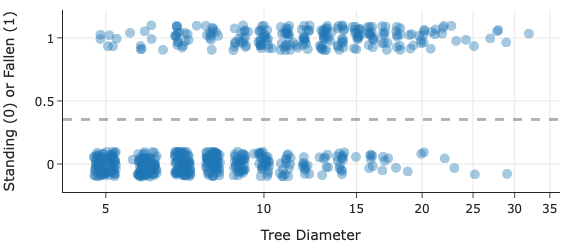

In [8]:
fig = px.scatter(x=jitter(trees['diameter'], amt=0.5), 
                 y = jitter(trees['status_0_1']), 
                 log_x=True, width=450, height=250)

fig.update_traces(marker=dict(opacity=0.4, size=10))
fig.add_hline(y=pr_fallen, line_width=3, line_dash="dash", line_color="black")
fig.update_layout(xaxis_title="Tree Diameter",
                  yaxis_title="Standing (0) or Fallen (1)")

fig

This scatter plot shows that the smaller trees are more likely to be standing than the larger trees. Notice that the average status for trees (0.35) essentially fits a constant model to the response variable. If we consider tree diameter as an explanatory feature, we should be able to improve the model.  

A starting place might be to compute the proportion of fallen trees for different diameters. The following block of code divides tree diameter into intervals and computes the proportion of fallen trees in each bin.

In [32]:
splits=[4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 25, 32]
tree_bins = (trees['status_0_1']
 .groupby(pd.cut(trees['diameter'], splits))
 .agg(['mean', 'count'])
 .rename(columns={'mean': 'proportion'})
 .assign(diameter=lambda df: [i.right for i in df.index])
)

We can plot these proportions against tree diameter:

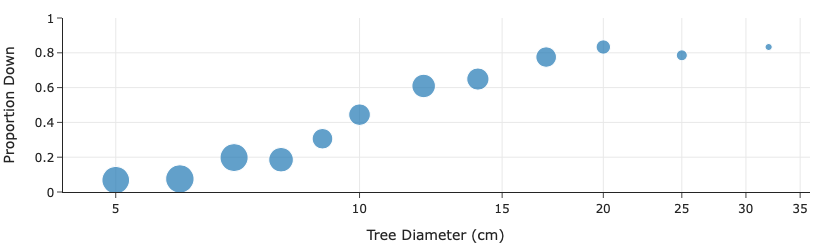

In [33]:
fig = px.scatter(tree_bins, x='diameter', y='proportion', size='count',
                 log_x=True, 
                 labels={'diameter':"Tree Diameter (cm)",
                         'proportion':"Proportion Down"},
                 width=450, height=250)

fig.update_layout(yaxis_range=[0, 1])
fig.show()

The size of the markers reflects the number of trees in the diameter bin. We can use these proportions to improve our model. For example, for a tree is 6 cm in diameter, we would classify it as standing, whereas for a 20 cm tree, our classification would be fallen. A natural starting place for binary classification is to model the observed proportions and then use these proportions to classify. Next, we'll develop a model for these proportions.